In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
tfds.__version__

'4.4.0'

In [2]:
# from tensorflow.io import read_file
# from tensorflow.image import decode_image
# import glob
# import os
# data_dir = '/data/Cat/*.jpg'
# for image in sorted(glob.glob(data_dir)):
#     img = read_file(str(image))
#     img = decode_image(img)
#     if img.shape[2] != 3:
#         print(image)
#         os.remove(image)

In [3]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    name='tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    data_dir='~/aiffel/flowers/',
    with_info=True,
    as_supervised=True,
)

print(raw_train)
print(raw_validation)
print(raw_test)

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


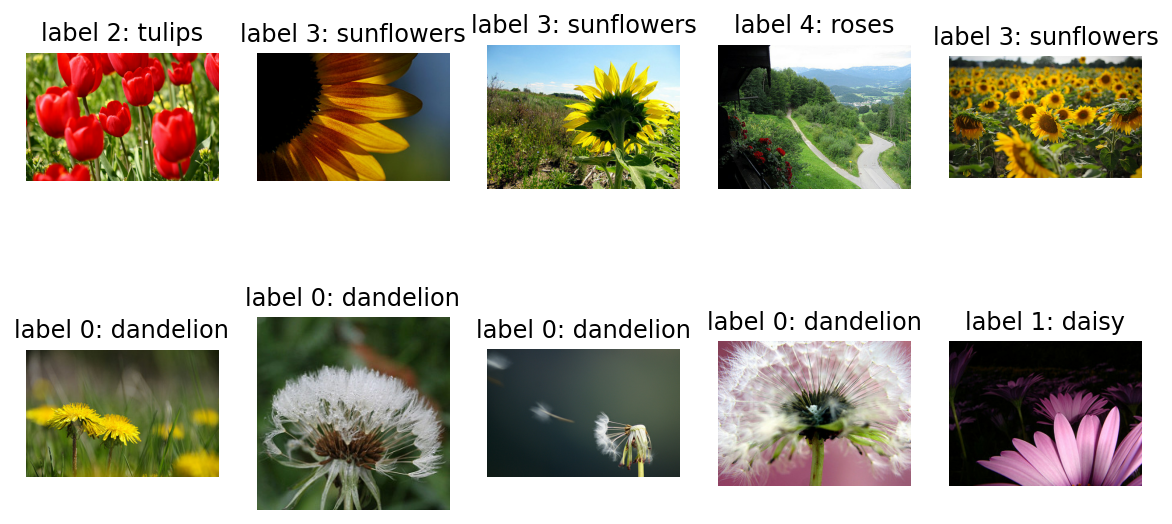

In [4]:
plt.figure(figsize=(10, 5))

get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(raw_train.take(10)):  # 10개의 데이터를 가져 옵니다.
    plt.subplot(2, 5, idx+1)
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

In [5]:
IMG_SIZE = 160 # 리사이징할 이미지의 크기

def format_example(image, label):
    image = tf.cast(image, tf.float32)  # image=float(image)같은 타입캐스팅의  텐서플로우 버전입니다.
    image = (image/127.5) - 1 # 픽셀값의 scale 수정
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label


In [6]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

print(train, len(train))
print(validation,len(validation))
print(test,len(test))

<MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)> 2936
<MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)> 367
<MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)> 367


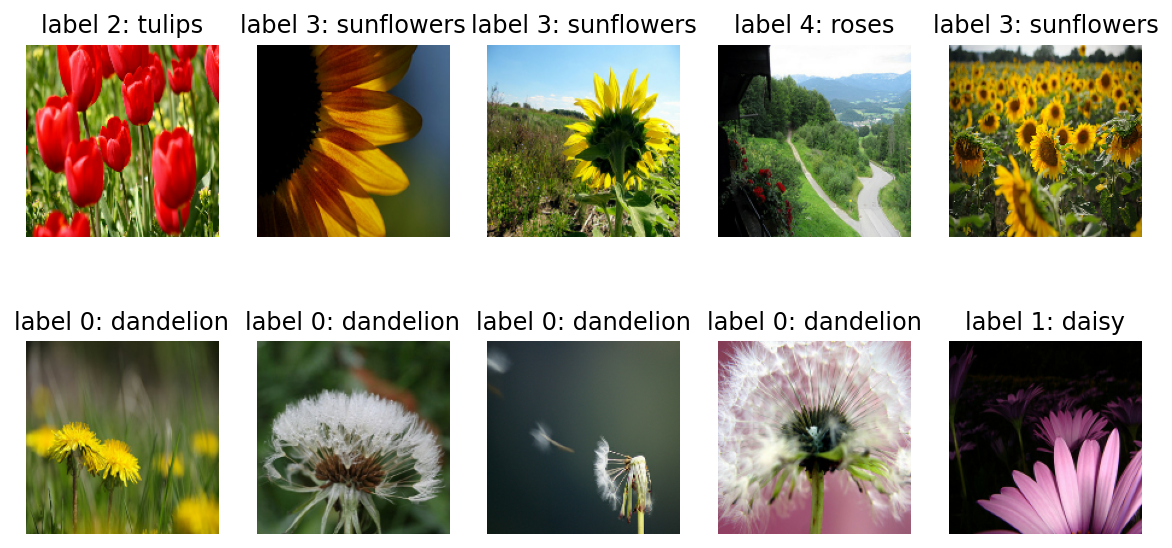

In [7]:
plt.figure(figsize=(10, 5))
get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(train.take(10)):
    plt.subplot(2, 5, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

In [8]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model VGG16
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')

In [9]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 80, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 40, 128)       0     

In [10]:
BATCH_SIZE = 20
SHUFFLE_BUFFER_SIZE = 1000
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [11]:
for image_batch, label_batch in train_batches.take(1):
    break

image_batch.shape, label_batch.shape

(TensorShape([20, 160, 160, 3]), TensorShape([20]))

In [12]:
feature_batch = base_model(image_batch)
feature_batch.shape

TensorShape([20, 5, 5, 512])

In [13]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [14]:
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(20, 512)


In [15]:
dense_layer = tf.keras.layers.Dense(512,activation='relu')
dp_layer = tf.keras.layers.Dropout(0.2)
# 활성화 함수는 Softmax를 사용합니다.
prediction_layer = tf.keras.layers.Dense(5,activation='softmax') 

prediction_batch = prediction_layer(dense_layer(feature_batch_average))  
print(prediction_batch.shape)

(20, 5)


In [16]:
base_model.trainable = False

model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  dense_layer,
    dp_layer,
  prediction_layer
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 5, 5, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 2565      
Total params: 14,979,909
Trainable params: 265,221
Non-trainable params: 14,714,688
_________________________________________________________________


In [17]:
learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [18]:
validation_steps=len(validation)/BATCH_SIZE
loss0, accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

18/18 [==============================] - 5s 120ms/step - loss: 1.6857 - accuracy: 0.2425
initial loss: 1.69
initial accuracy: 0.24


In [19]:
EPOCHS =10
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/10
147/147 [==============================] - 13s 79ms/step - loss: 0.8626 - accuracy: 0.6819 - val_loss: 0.5971 - val_accuracy: 0.7738
Epoch 2/10
147/147 [==============================] - 10s 62ms/step - loss: 0.5578 - accuracy: 0.8089 - val_loss: 0.5261 - val_accuracy: 0.8065
Epoch 3/10
147/147 [==============================] - 10s 63ms/step - loss: 0.4843 - accuracy: 0.8317 - val_loss: 0.4980 - val_accuracy: 0.8147
Epoch 4/10
147/147 [==============================] - 10s 63ms/step - loss: 0.4257 - accuracy: 0.8505 - val_loss: 0.4515 - val_accuracy: 0.8420
Epoch 5/10
147/147 [==============================] - 10s 63ms/step - loss: 0.3924 - accuracy: 0.8573 - val_loss: 0.4763 - val_accuracy: 0.8283
Epoch 6/10
147/147 [==============================] - 10s 63ms/step - loss: 0.3653 - accuracy: 0.8689 - val_loss: 0.4857 - val_accuracy: 0.8120
Epoch 7/10
147/147 [==============================] - 10s 63ms/step - loss: 0.3359 - accuracy: 0.8835 - val_loss: 0.4515 - val_accuracy:

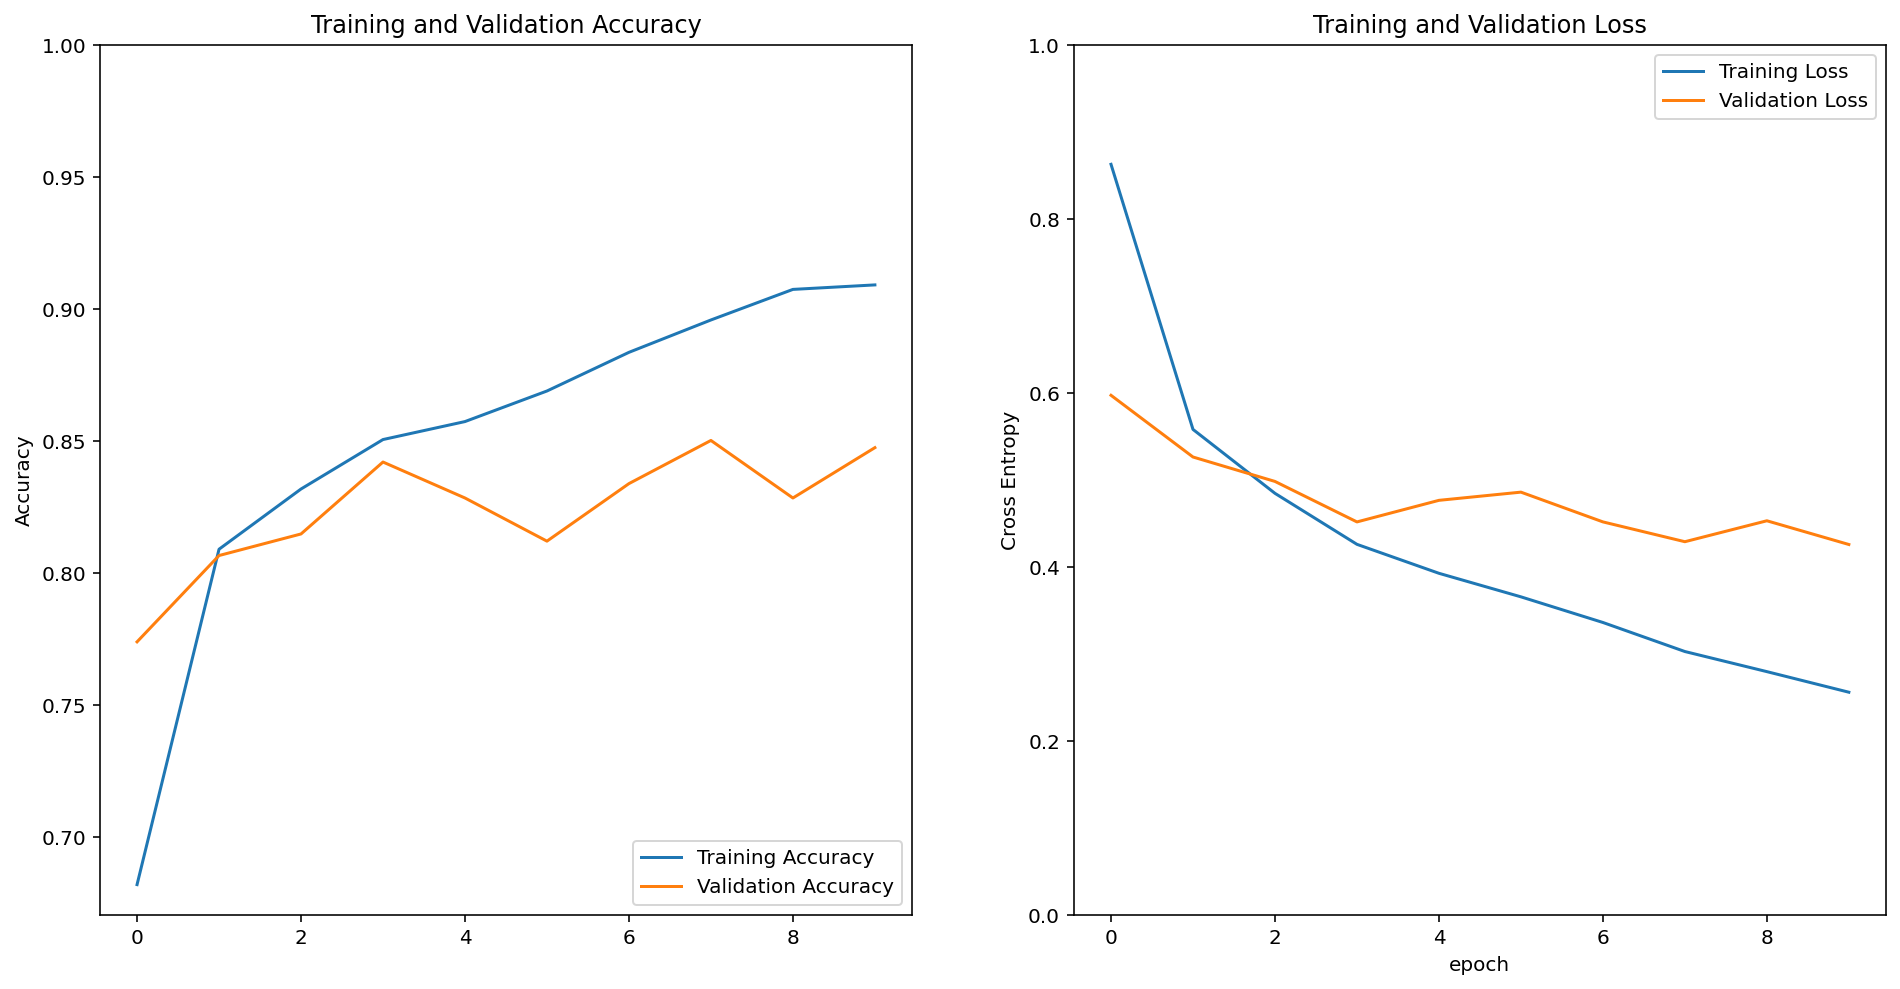

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# test에 대해 inference

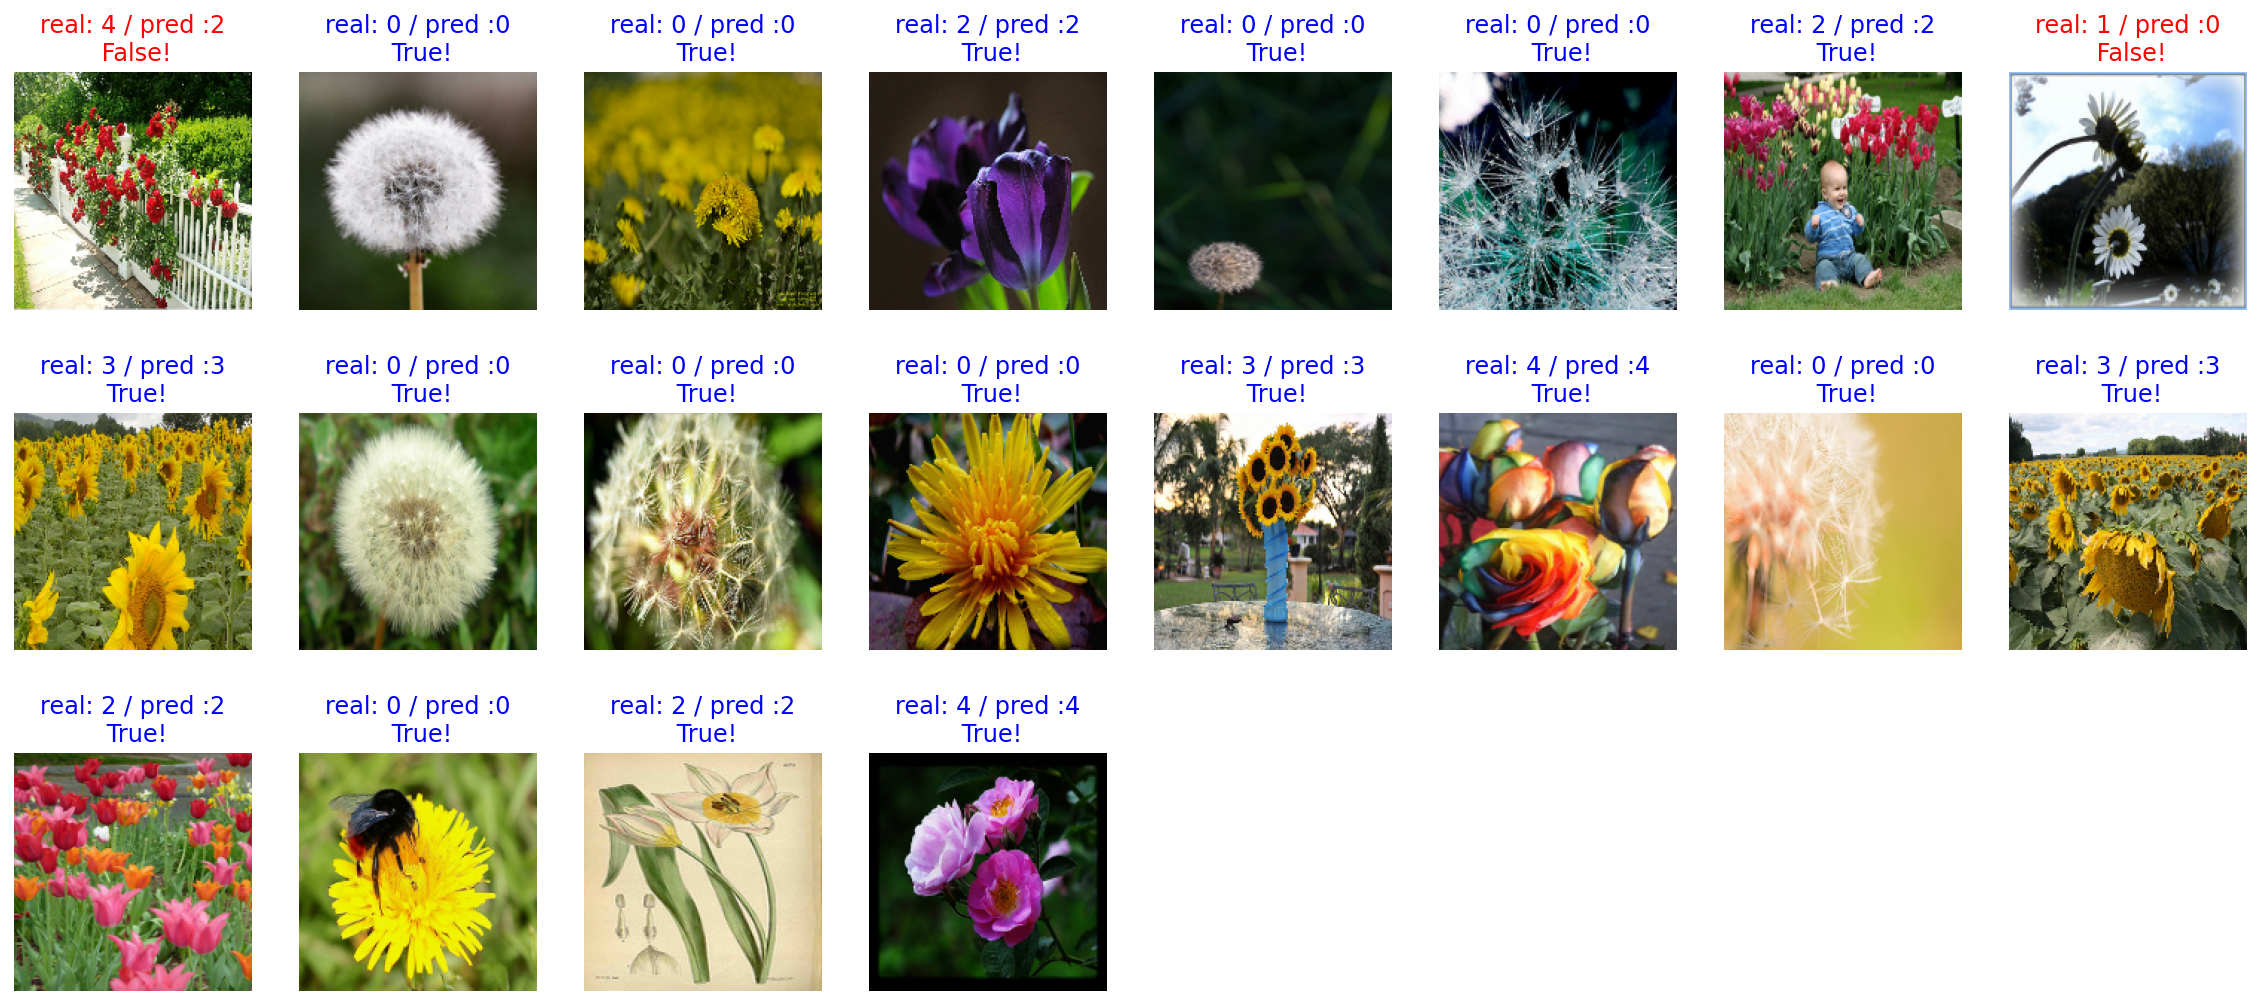

In [21]:
# 특정 batch inference 및 시각화
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    break

predictions = np.argmax(predictions, axis=1)
#predictions

plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})
    plt.axis('off')

In [22]:
count = 0
for image, label, prediction in zip(images, labels, predictions):
    correct = label == prediction
    if correct:
        count = count + 1

print(count / 20 * 100)

90.0


In [23]:
total_correct = 0
total_samples = 0

for image_batch, label_batch in test_batches:
    predictions = model.predict(image_batch)
    predicted_labels = np.argmax(predictions, axis=1)
    correct_predictions = np.sum(predicted_labels == label_batch)
    total_correct += correct_predictions
    total_samples += image_batch.shape[0]

accuracy = total_correct / total_samples
print("Accuracy on the test set: {:.2%}".format(accuracy))

Accuracy on the test set: 85.01%


In [24]:
import os

checkpoint_dir = os.getenv("HOME") + "/aiffel/flowers/checkpoint"
checkpoint_file_path = os.path.join(checkpoint_dir, 'checkpoint')

if not os.path.exists('checkpoint_dir'):
    os.mkdir('checkpoint_dir')
    
model.save_weights(checkpoint_file_path)     # checkpoint 파일 생성

if os.path.exists(checkpoint_file_path):
    print('checkpoint 파일 생성 OK!!')

checkpoint 파일 생성 OK!!


# 나만의 데이터에 적용

In [25]:
import os
img_dir_path = os.getenv("HOME") + "/aiffel/flowers/images"
os.path.exists(img_dir_path)

True

In [26]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [27]:
def show_and_predict_image(dirpath, filename, img_size=160):
    filepath = os.path.join(dirpath, filename)
    image = load_img(filepath, target_size=(img_size, img_size))
    plt.imshow(image)
    plt.axis('off')
    image = img_to_array(image).reshape(1, img_size, img_size, 3)
    predictions = (model.predict(image)[0])
    prediction_idx = np.argmax((model.predict(image)[0]))
    
    flower_lists = metadata.features['label'].names
    print(f"This image seems {flower_lists[prediction_idx]} with {np.max(predictions) * 100}%.")

This image seems roses with 100.0%.


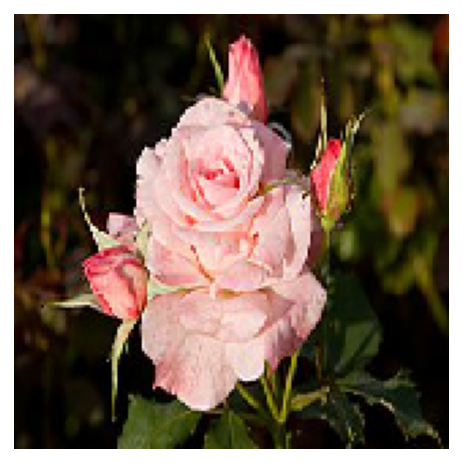

In [28]:
filename = 'rose.jpeg'
show_and_predict_image(img_dir_path, filename)

# 회고

## 발생한 문제 1 
19/20 [===========================>..] - ETA: 0s - loss: nan - accuracy: 0.1608WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 20 batches). You may need to use the repeat() function when building your dataset.

해결 방안 1 :
- steps_per_epoch의 값은 (Trainging size) / (batch_size)로 설정
- steps 바꿔보기 -> validation 문제 해결, train 문제도 자동으로 해결

pretrained model의 강력함은 상상이상이다. 이를 어떻게 transfer learning에 잘 활용할지에 대해서 먼저 고민하는 것이 최우선이고 만약 데이터의 유형이 많이 다를 경우에 어떻게 적용해보아야하는지도 잘 생각해봐야 될 것 같다.

# appendix

1. epoch 5 -> 10, lr : 0.0001 , dense : 512
    - 5에서 부터 overfitting의 양상이 보임
    - loss: 0.4857 - accuracy: 0.8433 - val_loss: 0.5163 - val_accuracy: 0.8202

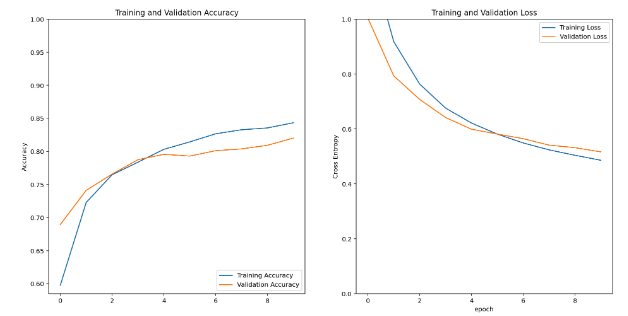

2. epoch 10 , lr : 0.0001, dense 512, drop out(0.2) 추가
- overfitting의 정도가 줄어들었다고 볼 수 있음
- loss: 0.5332 - accuracy: 0.8232 - val_loss: 0.5359 - val_accuracy: 0.8093

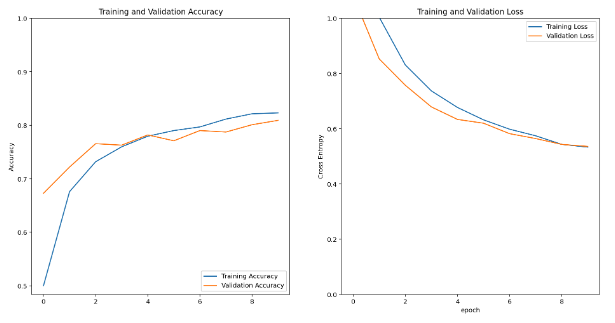

3. epoch 10, lr : 0.0001 , dense : 512, optimizer : RMSProp to Adam, Dropout O
- loss: 0.5260 - accuracy: 0.8260 - val_loss: 0.5438 - val_accuracy: 0.8065 TEST accuacry : 83.11%

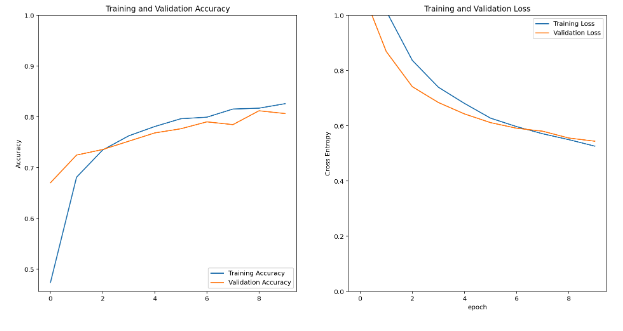

4. epoch 10 , lr : 0.001 dense 512, optimizer : Adam, Dropout O
    - 오버피팅의 가능성이 높다.
    - 하지만 test set의 성능이 높게 나타남
    - loss: 0.2557 - accuracy: 0.9091 - val_loss: 0.4255 - val_accuracy: 0.8474
    - Accuracy on the test set: 85.01%

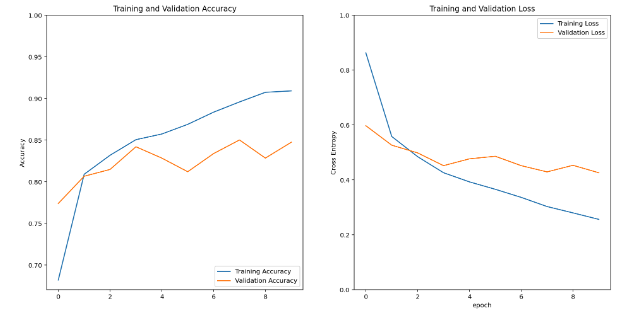